# Functions to read out AF3 output, calculate scores and plot results

In [2]:
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
from Bio.PDB import MMCIFParser
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from collections import Counter
from scipy.spatial.distance import pdist, squareform
import zipfile
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 # change this for high resolution output

warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

def transform_pae_matrix(pae_matrix, pae_cutoff):
    # Initialize the transformed matrix with zeros
    transformed_pae = np.zeros_like(pae_matrix)

    # Apply transformation: pae = 0 -> score = 1, pae = cutoff -> score = 0, above cutoff -> score = 0
    # Linearly scale values between 0 and cutoff to fall between 1 and 0
    within_cutoff = pae_matrix < pae_cutoff
    transformed_pae[within_cutoff] = 1 - (pae_matrix[within_cutoff] / pae_cutoff)
    
    return transformed_pae

def calculate_mean_lis(transformed_pae, subunit_number):
    # Calculate the cumulative sum of protein lengths to get the end indices of the submatrices
    cum_lengths = np.cumsum(subunit_number)
    
    # Add a zero at the beginning of the cumulative lengths to get the start indices
    start_indices = np.concatenate(([0], cum_lengths[:-1]))
    
    # Initialize an empty matrix to store the mean LIS
    mean_lis_matrix = np.zeros((len(subunit_number), len(subunit_number)))
    
    # Iterate over the start and end indices
    for i in range(len(subunit_number)):
        for j in range(len(subunit_number)):
            # Get the start and end indices of the interaction submatrix
            start_i, end_i = start_indices[i], cum_lengths[i]
            start_j, end_j = start_indices[j], cum_lengths[j]
            
            # Get the interaction submatrix
            submatrix = transformed_pae[start_i:end_i, start_j:end_j]
            
            # Calculate the mean LIS, considering only non-zero values
            mean_lis = submatrix[submatrix > 0].mean()
            
            # Store the mean LIS in the matrix
            mean_lis_matrix[i, j] = mean_lis
    
    return mean_lis_matrix

def calculate_contact_map(cif_file, distance_threshold=8):
    def read_cif_lines(cif_path):
        with open(cif_path, 'r') as file:
            lines = file.readlines()

        residue_lines = []
        for line in lines:
            if line.startswith('ATOM') and ('CB' in line or 'GLY' in line and 'CA' in line):
                residue_lines.append(line.strip())  # Store the line if it meets the criteria for ATOM

            if line.startswith('ATOM') and 'P   ' in line:
                residue_lines.append(line.strip()) # Store the line if it meets the criteria for ATOM

            elif line.startswith('HETATM'):
                residue_lines.append(line.strip())  # Store all HETATM lines

        return residue_lines

    def lines_to_dataframe(residue_lines):
        # Split lines and create a list of dictionaries for each atom
        data = []
        for line in residue_lines:
            parts = line.split()
            # Correctly convert numerical values
            for i in range(len(parts)):
                try:
                    parts[i] = float(parts[i])
                except ValueError:
                    pass
            data.append(parts)

        df = pd.DataFrame(data)

        # Add line number column
        df.insert(0, 'residue', range(1, 1 + len(df)))

        return df

    # Read lines from CIF file
    residue_lines = read_cif_lines(cif_file)

    # Convert lines to DataFrame
    df = lines_to_dataframe(residue_lines)

    # Assuming the columns for x, y, z coordinates are at indices 11, 12, 13 after insertion
    coordinates = df.iloc[:, 11:14].to_numpy()

    distances = squareform(pdist(coordinates))

    # Assuming the column for atom names is at index 3 after insertion
    has_phosphorus = df.iloc[:, 3].apply(lambda x: 'P' in str(x)).to_numpy()

    # Adjust the threshold for phosphorus-containing residues
    adjusted_distances = np.where(has_phosphorus[:, np.newaxis] | has_phosphorus[np.newaxis, :], 
                                  distances - 4, distances)

    contact_map = np.where(adjusted_distances < distance_threshold, 1, 0)
    return contact_map


def generate_json_paths(base_path, number_of_models=5):
    """
    Generates a list of paths to model-specific confidences.json files,
    where each model's outputs are in a 'seed-XYZ_sample-N' subdirectory.

    Parameters:
    - base_path (str): The base directory for a specific protein pair
                       (e.g., 'af3_outputs/positive-controls/ensg..._vs_ensg...').
    - number_of_models (int): The number of model runs (samples) to consider.

    Returns:
    - list: A list of fully qualified paths to the 'confidences.json' files.
    """
    json_files = []
    # Find the common seed prefix (e.g., 'seed-852950') from existing directories
    seed_prefix = None
    for item in os.listdir(base_path):
        if os.path.isdir(os.path.join(base_path, item)) and item.startswith("seed-") and "_sample-" in item:
            match = re.match(r"(seed-\d+)_sample-\d+", item)
            if match:
                seed_prefix = match.group(1)
                break
    
    if not seed_prefix:
        warnings.warn(f"Could not find any 'seed-XYZ_sample-N' subdirectories in {base_path}. Check path or naming convention.")
        return []

    for model in range(number_of_models):
        sample_subdir = f"{seed_prefix}_sample-{model}"
        json_path = os.path.join(base_path, sample_subdir, "confidences.json")
        if os.path.exists(json_path):
            json_files.append(json_path)
        else:
            warnings.warn(f"Missing {json_path}. It might be that not all {number_of_models} models were generated or the seed prefix is inconsistent.")
    return json_files


def afm3_plot_average_to_df(af3_jsons, pae_cutoff=12, distance_cutoff=8, result_save = "True"):
    sum_pae_matrix = None
    sum_transformed_pae_matrix = None
    sum_mean_lis_matrix = None
    sum_contact_lia_map = None
    sum_iptm_matrix = None
    all_interactions = []

    for af3_json_path_confidences in af3_jsons:
        # Load PAE data from confidences.json (assuming it contains PAE now)
        json_data = json.load(open(af3_json_path_confidences, 'rb'))
        
        # Derive path to summary_confidences.json for this specific model
        json_confidence_path = af3_json_path_confidences.replace("confidences.json", "summary_confidences.json")
        # Load confidence data from the derived path
        confidence_data = json.load(open(json_confidence_path, 'rb'))
        
        token_chain_ids = json_data['token_chain_ids']
        chain_residue_counts = Counter(token_chain_ids)
        subunit_number = list(chain_residue_counts.values())
        pae_matrix = np.array(json_data['pae']) # Assuming 'pae' key exists in confidences.json
        subunit_sizes = subunit_number
        
        # Derive path to model.cif for this specific model
        cif_file = af3_json_path_confidences.replace("confidences.json", "model.cif")
        
        transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)
        transformed_pae_matrix = np.nan_to_num(transformed_pae_matrix)
        lia_map = np.where(transformed_pae_matrix > 0, 1, 0)

        mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)
        mean_lis_matrix = np.nan_to_num(mean_lis_matrix)

        contact_map = calculate_contact_map(cif_file, distance_cutoff)
        combined_map = np.where((transformed_pae_matrix > 0) & (contact_map == 1), transformed_pae_matrix, 0)
        
        mean_clis_matrix = calculate_mean_lis(combined_map, subunit_sizes)
        mean_clis_matrix = np.nan_to_num(mean_clis_matrix)

        lia_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))
        lir_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))
        clia_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))
        clir_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))

        for i in range(len(subunit_sizes)):
            for j in range(len(subunit_sizes)):
                start_i, end_i = sum(subunit_sizes[:i]), sum(subunit_sizes[:i+1])
                start_j, end_j = sum(subunit_sizes[:j]), sum(subunit_sizes[:j+1])
                
                interaction_submatrix = lia_map[start_i:end_i, start_j:end_j]

                lia_matrix[i, j] = int(np.count_nonzero(interaction_submatrix))
                residues_i = np.unique(np.where(interaction_submatrix > 0)[0]) + start_i
                residues_j = np.unique(np.where(interaction_submatrix > 0)[1]) + start_j
                lir_matrix[i, j] = int(len(residues_i) + len(residues_j))

                combined_submatrix = combined_map[start_i:end_i, start_j:end_j]
                clia_matrix[i, j] = int(np.count_nonzero(combined_submatrix))

                residues_i = np.unique(np.where(combined_submatrix > 0)[0]) + start_i
                residues_j = np.unique(np.where(combined_submatrix > 0)[1]) + start_j
                clir_matrix[i, j] = int(len(residues_i) + len(residues_j))

        iptm_matrix = confidence_data['chain_pair_iptm']
        iptm_matrix = np.array(iptm_matrix, dtype=float)
        iptm_matrix = np.nan_to_num(iptm_matrix)

        if sum_pae_matrix is None:
            sum_pae_matrix = pae_matrix
            sum_transformed_pae_matrix = transformed_pae_matrix
            sum_mean_lis_matrix = mean_lis_matrix
            sum_contact_lia_map = combined_map
            sum_iptm_matrix = iptm_matrix
        else:
            sum_pae_matrix += pae_matrix
            sum_transformed_pae_matrix += transformed_pae_matrix
            sum_mean_lis_matrix += mean_lis_matrix
            sum_contact_lia_map += combined_map
            sum_iptm_matrix += iptm_matrix

        # Extract model number from the path (e.g., 'seed-XYZ_sample-0/confidences.json' -> 0)
        model_number_match = re.search(r'sample-(\d+)', af3_json_path_confidences)
        model_number = model_number_match.group(1) if model_number_match else 'unknown'

        # Get the protein pair folder name by going up two levels from confidences.json
        folder_name = os.path.basename(os.path.dirname(os.path.dirname(af3_json_path_confidences)))
        for i in range(len(subunit_sizes)):
            for j in range(len(subunit_sizes)):
                interaction = {
                    'folder_name': folder_name,
                    'model_number': model_number,
                    'protein_1': i + 1,
                    'protein_2': j + 1,
                    'LIS': mean_lis_matrix[i, j],
                    'LIA': lia_matrix[i, j],
                    'LIR': lir_matrix[i, j],
                    'cLIS': mean_clis_matrix[i, j],
                    'cLIA': clia_matrix[i, j],
                    'cLIR': clir_matrix[i, j],
                    'iptm': iptm_matrix[i, j],
                }
                all_interactions.append(interaction)

    avg_pae_matrix = sum_pae_matrix / len(af3_jsons)
    avg_transformed_pae_matrix = sum_transformed_pae_matrix / len(af3_jsons)
    avg_mean_lis_matrix = sum_mean_lis_matrix / len(af3_jsons)
    avg_contact_lia_map = sum_contact_lia_map / len(af3_jsons)
    avg_iptm_matrix = sum_iptm_matrix / len(af3_jsons)

    avg_pae_matrix = np.nan_to_num(avg_pae_matrix)
    avg_transformed_pae_matrix = np.nan_to_num(avg_transformed_pae_matrix)
    avg_mean_lis_matrix = np.nan_to_num(avg_mean_lis_matrix)
    avg_iptm_matrix = np.nan_to_num(avg_iptm_matrix)

    df_interactions = pd.DataFrame(all_interactions)
    df_interactions['interaction'] = df_interactions.apply(lambda row: tuple(sorted((row['protein_1'], row['protein_2']))), axis=1)
    df_merged = df_interactions.groupby(['folder_name', 'model_number', 'interaction']).mean().reset_index()
    df_merged[['protein_1', 'protein_2']] = pd.DataFrame(df_merged['interaction'].tolist(), index=df_merged.index)
    df_merged = df_merged.drop(columns=['interaction'])

    # Calculate average values for each protein pair and add as new rows
    avg_rows = []
    interaction_pairs = df_merged.groupby(['protein_1', 'protein_2'])

    for (protein_1, protein_2), group in interaction_pairs:
        avg_row = {
            'folder_name': folder_name,
            'model_number': 'average',
            'protein_1': protein_1,
            'protein_2': protein_2,
            'LIS': group['LIS'].mean(),
            'LIA': group['LIA'].mean(),
            'LIR': group['LIR'].mean(),
            'cLIS': group['cLIS'].mean(),
            'cLIA': group['cLIA'].mean(),
            'cLIR': group['cLIR'].mean(),
            'iptm': group['iptm'].mean(),
        }
        avg_rows.append(avg_row)

    df_avg = pd.DataFrame(avg_rows)
    df_merged = pd.concat([df_merged, df_avg], ignore_index=True)

    df_merged['LIA'] = df_merged['LIA'].astype(int)
    df_merged['LIR'] = df_merged['LIR'].astype(int)
    df_merged['cLIA'] = df_merged['cLIA'].astype(int)
    df_merged['cLIR'] = df_merged['cLIR'].astype(int)

    # Save DataFrame to CSV
    output_folder = os.path.dirname(af3_jsons[0])
    output_path = os.path.join(output_folder, f"{folder_name}_lis_analysis.csv")
    if result_save == "True":
        df_merged.to_csv(output_path, index=False)
        print("Results saved to: ", output_path)
        print(f"{folder_name}_lis_analysis.csv")

    return df_merged


mpl.rcParams['figure.dpi'] = 150

# Function to extract average LIS for protein 1 and 2 from df_interactions
def extract_lis_from_df(df_interactions):
    row = df_interactions.loc[(df_interactions['model_number'] == '0') &
                              (df_interactions['protein_1'] == 1) &
                              (df_interactions['protein_2'] == 2)]
    if not row.empty:
        return row['LIS'].values[0]
    return np.nan

# Function to compute average iPTM from the _summary_confidences_*.json files
def calculate_average_iptm(json_files):
    iptm_values = []
    for json_file in json_files:
        with open(json_file, 'r') as f:
            data = json.load(f)
            iptm_values.append(data.get('iptm', 0))
    if iptm_values:
        return np.mean(iptm_values)
    return np.nan

# Function to unzip and delete zip files in the subdirectory
def unzip_and_cleanup(dir_path):
    for file in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file)
        if file.endswith(".zip") and os.path.isfile(file_path):
            # Create a directory with the same name as the zip file (without .zip)
            extract_dir = os.path.join(dir_path, file[:-4])  # Remove '.zip' extension
            os.makedirs(extract_dir, exist_ok=True)  # Create the directory if it doesn't exist

            # Extract all contents into the newly created directory
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)  # Extract contents into the new directory

            os.remove(file_path)  # Delete the zip file after extraction

# Function to process a given subdirectory
def process_subdirectory(subdir_path, identity, pae_cutoff=12, distance_cutoff=8):    
    # Generate paths to confidences.json for each model run
    af3_confidences_jsons = generate_json_paths(subdir_path, number_of_models=5)
    
    # Pass these to afm3_plot_average_to_df, which will internally derive summary_confidences.json and model.cif paths
    df_interactions = afm3_plot_average_to_df(af3_confidences_jsons, pae_cutoff=pae_cutoff, distance_cutoff=distance_cutoff, result_save=False)
    
    lis_value = extract_lis_from_df(df_interactions)
    
    # Generate paths to summary_confidences.json for each model for calculating the average iPTM
    summary_json_paths_for_avg_iptm = []
    for conf_json_path in af3_confidences_jsons:
        summary_path = conf_json_path.replace("confidences.json", "summary_confidences.json")
        if os.path.exists(summary_path):
            summary_json_paths_for_avg_iptm.append(summary_path)
        else:
            warnings.warn(f"Missing {summary_path} when calculating average iPTM.")

    avg_iptm = calculate_average_iptm(summary_json_paths_for_avg_iptm) # Call with the correctly derived paths
    
    # Correctly parse protein names from the 'P1_vs_P2' directory structure
    protein_name_parts = os.path.basename(subdir_path).split("_vs_")
    protein1 = protein_name_parts[0]
    protein2 = protein_name_parts[1]

    new_row = pd.DataFrame([{
        'P2P': f"{protein1}-{protein2}",
        'protein1': protein1,
        'protein2': protein2,
        'iPTM': avg_iptm,
        'LIS': lis_value,
        'identity': identity
    }])
    return new_row

# Main function to process the dataset and create the results dataframe
def process_dataset(data_dir, pae_cutoff=12, distance_cutoff=8):
    results_df = pd.DataFrame(columns=['P2P', 'protein1', 'protein2', 'iPTM', 'LIS', 'identity'])

    for child_dir in os.listdir(data_dir):
        child_dir_path = os.path.join(data_dir, child_dir)
        
        if os.path.isdir(child_dir_path):
            identity = ""
            if child_dir.lower() == 'negative-controls' or child_dir.lower() == 'negative_controls':
                identity = "negative control"
            elif child_dir.lower() == 'positive-controls' or child_dir.lower() == 'positive_controls':
                identity = "positive control"
            else:
                identity = child_dir  # Use directory name for non-control categories
            
            unzip_and_cleanup(child_dir_path)

            for subdir in os.listdir(child_dir_path):
                subdir_path = os.path.join(child_dir_path, subdir)
                if os.path.isdir(subdir_path):
                    new_row = process_subdirectory(subdir_path, identity, pae_cutoff, distance_cutoff)
                    results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df

# Plotting function
def plot_results(results_df, highlight_labels, general_label, DATA_DIR):
    neg_controls = results_df[results_df['identity'] == 'negative control']
    pos_controls = results_df[results_df['identity'] == 'positive control']
    
    # Check if general_label is a list and filter accordingly
    if isinstance(general_label, list):
        general_label_data = results_df[results_df['identity'].isin(general_label)]
        general_palette = sns.color_palette("cool", len(general_label))  # Palette for general_label points
    else:
        general_label_data = results_df[results_df['identity'] == general_label]
        general_palette = ["blue"]  # Single color if only one label

    # Create a color palette for the highlighted points
    highlight_palette = sns.color_palette("husl", len(highlight_labels))

    plt.figure(figsize=(6, 6))
    
    # Plot the points for general_label(s)
    if not general_label_data.empty:
        for idx, label in enumerate(general_label if isinstance(general_label, list) else [general_label]):
            label_data = general_label_data[general_label_data['identity'] == label]
            plt.scatter(label_data['iPTM'], label_data['LIS'], color=general_palette[idx], 
                        label=label, s=50, edgecolor='black')
    
    if not neg_controls.empty:
        plt.scatter(neg_controls['iPTM'], neg_controls['LIS'], color='red', label='negative control')
    
    if not pos_controls.empty:
        plt.scatter(pos_controls['iPTM'], pos_controls['LIS'], color='green', label='positive control')
    
    # Plot highlighted points for each label in the list
    for i, highlight_label in enumerate(highlight_labels):
        highlighted_points = results_df[results_df['P2P'] == highlight_label]
        if not highlighted_points.empty:
            plt.scatter(highlighted_points['iPTM'], highlighted_points['LIS'], 
                        color=highlight_palette[i], label=f'highlight: {highlight_label}', s=50, edgecolor='black')

    plt.axvline(0, c="black")
    plt.axhline(0, c="black")
    plt.title(f'Protein-Protein Interaction Scores from AlphaFold3')
    plt.xlabel('iPTM')
    plt.ylabel('LIS')
    plt.legend()
    plt.xlim(0, )
    plt.ylim(0, )
    plt.savefig(f'{RES_DIR}LIS-to-iPTM-plot.svg', format='svg', bbox_inches='tight')
    plt.show()

# Plot AlphaFold3 results

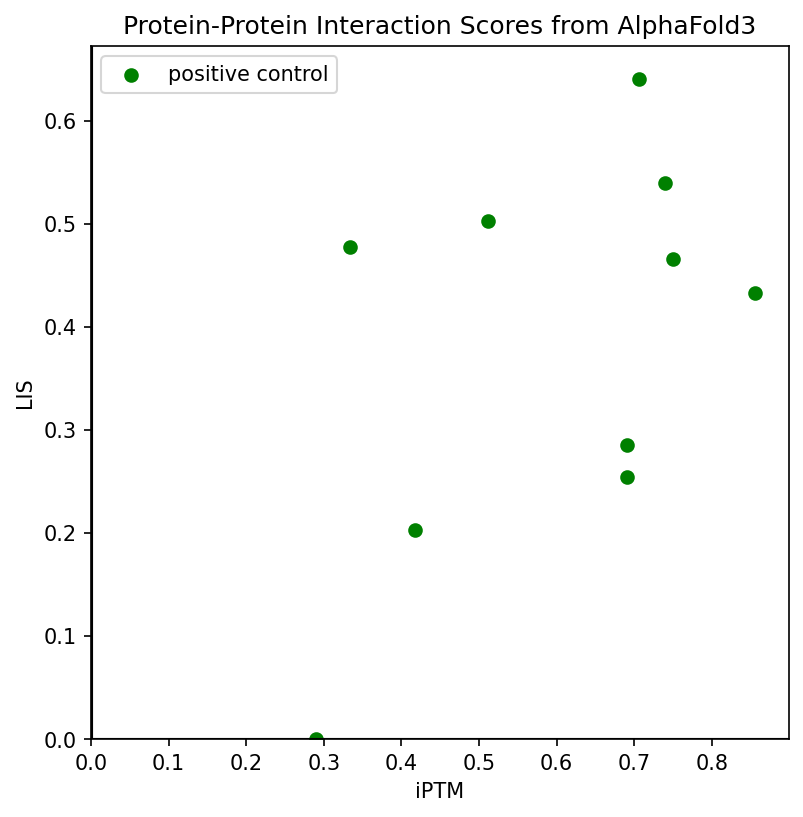

In [3]:
DATA_DIR = "af3_outputs/"
RES_DIR = "results/"
pae_cutoff = 12
distance_cutoff = 8

os.makedirs(RES_DIR, exist_ok=True)

# Run the full dataset processing
results_df = process_dataset(DATA_DIR, pae_cutoff, distance_cutoff)

# Save the results
results_df.to_csv(f'{RES_DIR}final_results.csv', index=False)

# Plot the results
plot_results(results_df, [], 'tested P2P-Int', RES_DIR)